In [35]:
# Start by importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from rich import print

In [36]:
# Need a way to represent the graph easily so that the algorithm can be implemented
# I will use a dictionary tp represent the graph
# The keys will be the nodes and the values will be adjacent nodes
# The graph will be undirected and weighted

nodes = ['A', 'B', 'C', 'D', 'E', 'F']
edges = {
    ('A', 'B'): 3,
    ('A', 'D'): 1,
    ('A', 'C'): 6,
    ('B', 'C'): 5,
    ('B', 'D'): 9,
    ('C', 'D'): 7,
    ('C', 'F'): 5,
    ('D', 'E'): 2,
    ('E', 'F'): 3,
    ('F', 'B'): 2
}

In [37]:
# Need a way to print the graph so that it is easy to visualize using networkx
def print_graph(nodes, edges, layout=nx.shell_layout):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    for (u, v), weight in edges.items():
        G.add_edge(u, v, weight=weight)
    
    pos = layout(G)  # Get the position layout for nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=8, font_weight='bold')

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.show()

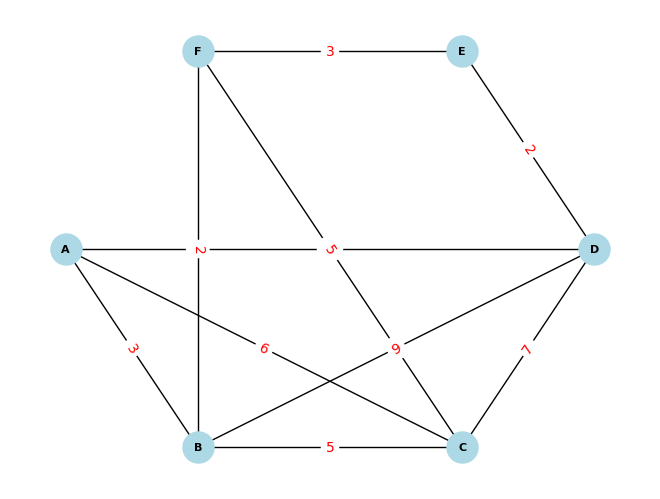

In [38]:
print_graph(nodes, edges)

In [39]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
from tqdm import tqdm

def boruvka(nodes, edges, animation=False, show_figure=False, progress=False):
    sets = {x: i for i, x in enumerate(nodes)}
    mst = {}
    frames = []  # To store graph states for the animation

    # Using tqdm for progress bar if progress is True
    if progress:
        print('Calculating number of iterations...')
    iteration_range = tqdm(range(len(set(sets.values())) - 1)) if progress else range(len(set(sets.values())) - 1)

    if progress:
        print("Running Boruvka's Algorithm...")

    for _ in iteration_range:
        min_edges = {}
        for edge in edges:
            node1, node2 = edge
            set1, set2 = sets[node1], sets[node2]

            if set1 != set2:
                if set1 not in min_edges or edges[edge] < edges[min_edges[set1]]:
                    min_edges[set1] = edge
                if set2 not in min_edges or edges[edge] < edges[min_edges[set2]]:
                    min_edges[set2] = edge

        for edge in min_edges.values():
            node1, node2 = edge
            set1, set2 = sets[node1], sets[node2]

            if set1 != set2:
                for k in sets:
                    if sets[k] == set2:
                        sets[k] = set1
                mst[edge] = edges[edge]

            if animation:
                frame = nx.Graph()
                frame.add_nodes_from(nodes)
                for edge, weight in edges.items():
                    frame.add_edge(edge[0], edge[1], weight=weight, color='blue' if edge in mst else 'red')
                frames.append(frame.copy())

    if animation:
        save_animation(frames, "boruvka_process.gif", show_figure)
    
    return mst

def update_graph(num, frames, G, pos, ax):
    ax.clear()
    frame = frames[num]
    colors = nx.get_edge_attributes(frame, 'color').values()
    nx.draw(frame, pos, edge_color=colors, with_labels=True, ax=ax)

def save_animation(frames, filename, show_figure):
    fig, ax = plt.subplots()
    G = nx.Graph()
    G.add_nodes_from(frames[0].nodes())
    pos = nx.shell_layout(G)

    ani = FuncAnimation(fig, update_graph, frames=len(frames), fargs=(frames, G, pos, ax), interval=1000, repeat_delay=1000)
    ani.save(filename, writer='pillow')
    plt.savefig(filename.split('.')[0] + '.png', dpi=800)
    if not show_figure:
        plt.close(fig)


In [40]:
mst = boruvka(nodes, edges, animation=True, show_figure=False)

In [41]:
mst

{('A', 'D'): 1, ('F', 'B'): 2, ('B', 'C'): 5, ('D', 'E'): 2, ('A', 'B'): 3}

Original Graph

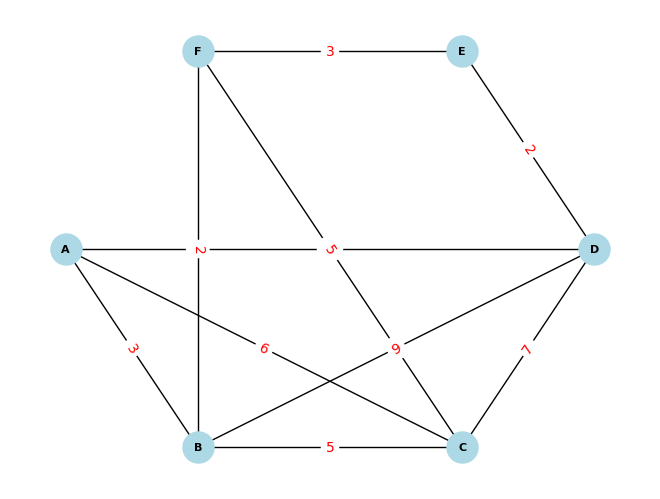

Minimum Spanning Tree

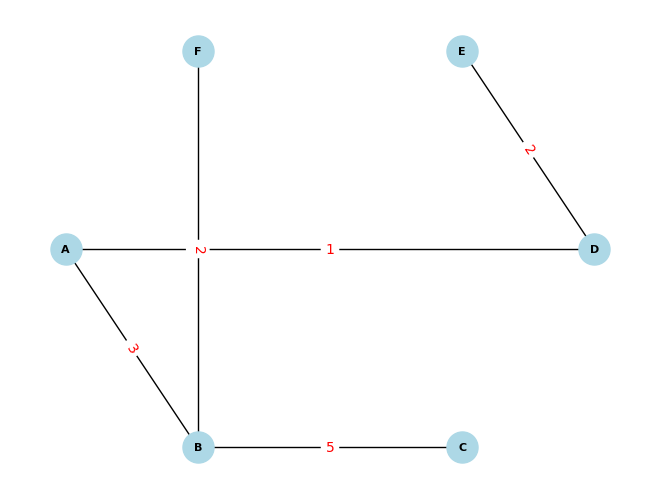

In [42]:
print('[bold]Original Graph')
print_graph(nodes, edges)
print('Minimum Spanning Tree')
print_graph(nodes, mst)

In [43]:
# Generate a random graph
import random

def generate_random_connected_graph(n, m):
    # Generate node names (e.g., 'A', 'B', 'C', ..., 'Z', 'AA', 'AB', ...)
    nodes = [chr(65 + i) if i < 26 else chr(64 + i // 26) + chr(65 + i % 26) for i in range(n)]

    # Ensure the graph is connected by creating a path that visits each node once
    # Shuffle the nodes to ensure the path is random
    shuffled_nodes = random.sample(nodes, n)
    # Connect the shuffled nodes with edges
    edges = {(shuffled_nodes[i], shuffled_nodes[i + 1]): random.randint(1, 10) for i in range(n - 1)}

    # Create all possible edges between nodes except the ones already in the path
    all_possible_edges = [(nodes[i], nodes[j]) for i in range(n) for j in range(i+1, n) if (nodes[i], nodes[j]) not in edges]

    # Randomly select additional edges to add, ensuring not to exceed m or the number of remaining possible edges
    additional_edges_count = min(m - (n - 1), len(all_possible_edges))
    if additional_edges_count > 0:
        additional_random_edges = random.sample(all_possible_edges, additional_edges_count)
        # Assign a random weight to each additional edge
        additional_edges = {edge: random.randint(1, 10) for edge in additional_random_edges}
        # Add the additional edges to the graph
        edges.update(additional_edges)

    return nodes, edges

nodes, edges = generate_random_connected_graph(10, 20)

In [44]:

def print_edges_table(edges):
    # Create the DataFrame with edges as index
    df = pd.DataFrame.from_dict(edges, orient='index', columns=['Weight'])
    # Reset the index to get the edges as a column
    df.reset_index(inplace=True)
    # Rename the columns appropriately
    df.columns = ['Edges', 'Weight']
    df.index = np.arange(1, len(df) + 1)
    return df


print_edges_table(edges)

,Edges,Weight
1,"(J, B)",1
2,"(B, A)",4
3,"(A, H)",10
4,"(H, G)",6
5,"(G, D)",10
6,"(D, C)",8
7,"(C, E)",6
8,"(E, F)",9
9,"(F, I)",4
10,"(G, I)",3


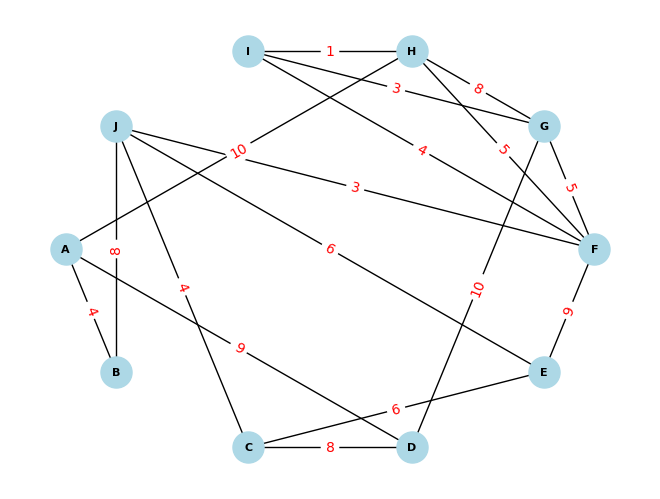

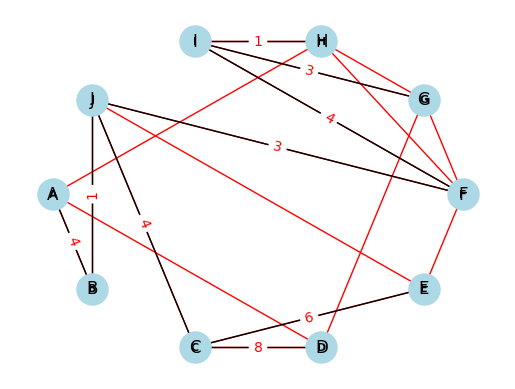

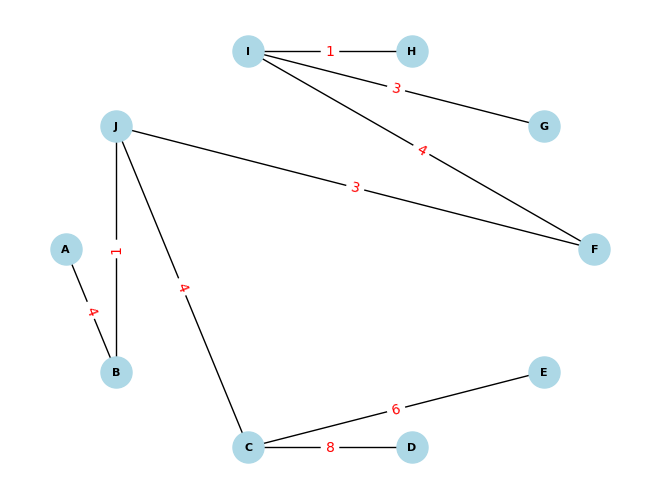

In [45]:
# Run the algorithm on the random graph
layout = nx.shell_layout
print_graph(nodes, edges, layout=layout)

mst = boruvka(nodes, edges, animation=True, show_figure=True)
print_graph(nodes, mst)
print_graph(nodes, mst)


In [46]:
# Total weight of the minimum spanning tree
sum(mst.values())

34

In [47]:
# Boruvka's Algorithm can also be used to create a perfect maze
# A perfect maze is a maze that has no loops and no isolated walls
# I will use the same algorithm, but I will change the graph so that it is a maze
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_maze(maze):
    # Assuming 'maze' is a 2D NumPy array where walls are represented by 1s and paths by 0s
    cmap = mcolors.ListedColormap(['white', 'black'])  # white for paths, black for walls
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap=cmap, interpolation='none')
    plt.axis('off')  # Turn off the axis
    plt.show()
    

In [48]:
# Need to initialise a graph that contains all of the points in the maze where the maze is a 2D numpy array where edges and nodes are 0s
import matplotlib.colors as mcolors

def apply_gradient(maze):
    """
    Apply a gradient to the path (2) in the maze.
    This function assumes a simple linear path for the sake of demonstration.
    """
    # Find the path cells
    path_indices = np.argwhere(maze == 2)

    # Create a gradient
    n = len(path_indices)
    gradient = np.linspace(0, 1, n)

    # Apply the gradient to the path cells
    for i, (r, c) in enumerate(path_indices):
        maze[r, c] = gradient[i] + 2  # Offset by 2 to distinguish from walls and open paths

    return maze

def plot_maze(maze):
    # Apply gradient
    gradient_maze = apply_gradient(maze.copy())

    # If there is just 1s and 0s in the maze, use a simple black and white colormap
    if np.array_equal(np.unique(maze), np.array([0, 1])):
        cmap = mcolors.ListedColormap(['white', 'black'])
    else:
        # Create a custom colormap
        # 0 -> white (open path), 1 -> black (walls), 2-3 -> gradient
        cmap = mcolors.LinearSegmentedColormap.from_list('maze_cmap', ['white', 'black', 'blue', 'red'])
        bounds = [0,1,2,3]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10, 10))
    plt.imshow(gradient_maze, cmap=cmap, interpolation='none')
    plt.axis('off')  # Turn off the axis
    plt.show()


size = 20
nodes = []

for i in range(0, size, 2):
    for j in range(0, size, 2):
        nodes.append((i, j))


# Initialise the edges
edges = {}

# get min and max x and y values
min_x = 0
max_x = size - 2
min_y = 0
max_y = size - 2

for node in nodes:
    x = node[0]
    y = node[1]
    # Get the adjacent nodes
    adjacent_nodes = [(x+2, y), (x-2, y), (x, y+2), (x, y-2)]
    # Remove the adjacent nodes that are not in the maze
    # Add the edges to the graph
    for adjacent_node in adjacent_nodes:
        if adjacent_node[0] >= min_x and adjacent_node[0] <= max_x and adjacent_node[1] >= min_y and adjacent_node[1] <= max_y:
            edges[(node, adjacent_node)] = random.randint(1, 10)

# print(nodes)
# print(edges)


In [49]:
maze = boruvka(nodes, edges)

In [50]:
def midpoint(x, y):
    return (x + y) // 2

def map_point(p):
    return (p[0] * 2, p[1] * 2)

def convert_to_np(nodes, mst, path=None):
    # need to convert the mst to a numpy array
    # need to get the min and max x and y values
    min_x = min([x[0] for x in nodes])
    max_x = max([x[0] for x in nodes])
    min_y = min([x[1] for x in nodes])
    max_y = max([x[1] for x in nodes])
    
    # need to create a numpy array of the correct size
    size_x = max_x - min_x + 1
    size_y = max_y - min_y + 1
    
    np_mst = np.zeros((size_x, size_y))
    
    
    for n1, n2 in mst:
        np_mst[n1] = 1
        np_mst[n2] = 1
        # need to get the midpoint between the two nodes
        mid_x = midpoint(n1[0], n2[0])
        mid_y = midpoint(n1[1], n2[1])
        np_mst[mid_x][mid_y] = 1        
        
        
    if path:
        # Need to add the path to the numpy array as 2
        for p in path:
            np_mst[p] = 2
        
        return np_mst
    else:
        return np_mst

In [51]:
maze

{((0, 2), (0, 0)): 4,
 ((2, 2), (2, 0)): 4,
 ((0, 2), (0, 4)): 3,
 ((2, 2), (4, 2)): 1,
 ((0, 4), (0, 6)): 1,
 ((2, 4), (4, 4)): 1,
 ((2, 6), (0, 6)): 1,
 ((0, 8), (2, 8)): 7,
 ((2, 6), (2, 8)): 5,
 ((0, 10), (0, 12)): 8,
 ((2, 10), (4, 10)): 2,
 ((0, 14), (0, 12)): 2,
 ((2, 14), (2, 12)): 2,
 ((0, 18), (0, 16)): 1,
 ((0, 16), (2, 16)): 3,
 ((0, 18), (2, 18)): 3,
 ((4, 0), (4, 2)): 2,
 ((2, 6), (4, 6)): 3,
 ((4, 6), (4, 8)): 4,
 ((4, 10), (4, 12)): 2,
 ((4, 12), (4, 14)): 2,
 ((4, 18), (4, 16)): 1,
 ((6, 0), (8, 0)): 4,
 ((6, 2), (8, 2)): 3,
 ((6, 6), (6, 4)): 1,
 ((6, 8), (6, 6)): 1,
 ((8, 10), (6, 10)): 4,
 ((6, 14), (6, 12)): 1,
 ((6, 16), (6, 18)): 4,
 ((4, 18), (6, 18)): 4,
 ((8, 0), (8, 2)): 2,
 ((8, 4), (8, 6)): 2,
 ((8, 8), (8, 6)): 1,
 ((8, 8), (8, 10)): 1,
 ((8, 12), (10, 12)): 2,
 ((6, 14), (8, 14)): 2,
 ((8, 14), (8, 16)): 2,
 ((8, 18), (8, 16)): 2,
 ((10, 0), (8, 0)): 5,
 ((10, 2), (10, 4)): 1,
 ((10, 6), (10, 8)): 2,
 ((10, 10), (10, 8)): 2,
 ((10, 14), (10, 16)): 1,
 ((1

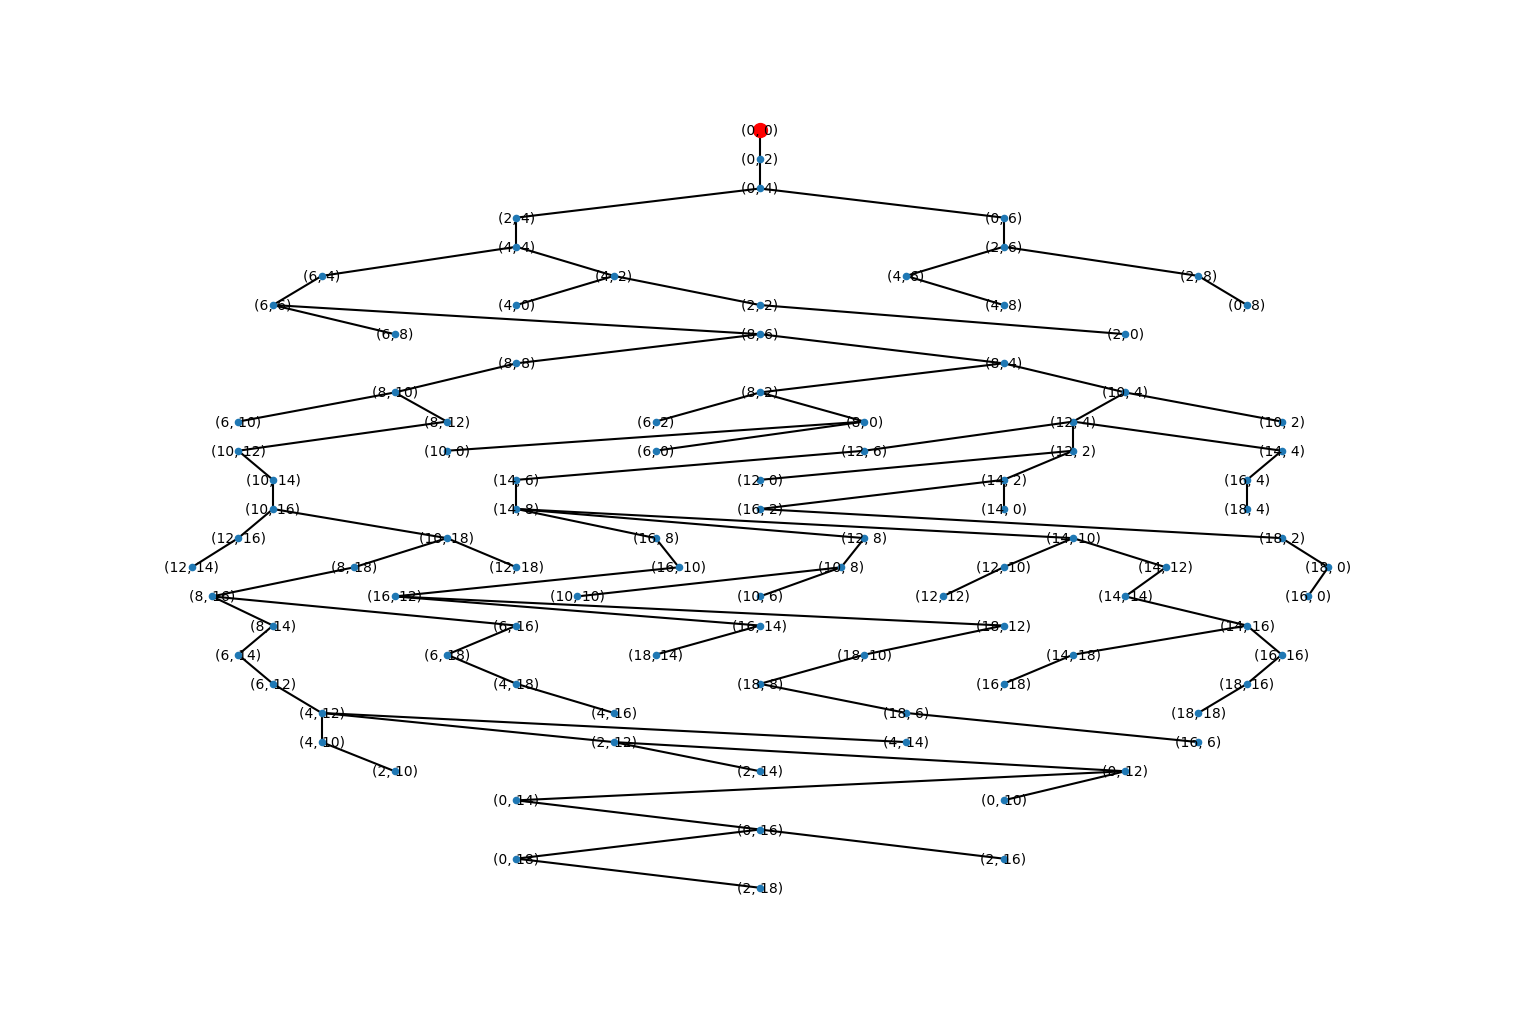

In [52]:
from collections import defaultdict
def tree_layout(G, root_node, width=1.0, vert_gap=1.5):
    # Use BFS to determine levels
    levels = defaultdict(list)
    queue = [(root_node, 0)]
    while queue:
        node, level = queue.pop(0)
        levels[level].append(node)
        for child in set(G.neighbors(node)) - set(levels[level - 1]):
            queue.append((child, level + 1))
    
    pos = {}
    for level, nodes in levels.items():
        # Horizontal position is determined by the order in the level list
        horiz_gap = width / (len(nodes) + 1)
        for i, node in enumerate(nodes):
            pos[node] = ((i + 1) * horiz_gap, -level * vert_gap)
    
    return pos

def print_graph_maze(edges, root_node):
    G = nx.Graph()
    
    # Adding weighted edges to the graph
    for (src, dst), weight in edges.items():
        G.add_edge(src, dst, weight=weight)

    # Creating a layout with the specified root node
    pos = tree_layout(G, root_node)

    # Draw the graph using the custom tree layout
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    nx.draw(G, pos, node_size=20, with_labels=True, font_size=10, width=1.5)
    
    # Show edge weights
    edge_labels = {(src, dst): G[src][dst]['weight'] for src, dst in G.edges()}
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5)
    nx.draw_networkx_nodes(G, pos, nodelist=[root_node], node_size=100, node_color='red')
    # Set margins to prevent clipping of node labels and display the plot
    plt.margins(0.1)
    plt.show()


root_node = (0, 0)
print_graph_maze(maze, root_node)

In [53]:
def print_maze_nx(edges):
    G = nx.Graph()
    
    # Adding weighted edges to the graph
    for (src, dst), weight in edges.items():
        G.add_edge(src, dst, weight=weight)
    
    # Use the actual grid coordinates for positioning
    pos = {node: (node[1], -node[0]) for node in G.nodes()}  # Flip y-axis for visual alignment
    
    # Draw the graph using the grid positions
    plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
    nx.draw(G, pos, node_size=10, with_labels=True, font_size=12, width=1.5, font_color='red')
    
    # Show edge weights
    edge_labels = {(src, dst): G[src][dst]['weight'] for src, dst in G.edges()}
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    nx.draw_networkx_nodes(G, pos, nodelist=[root_node], node_size=10, node_color='red')
    
    # Set margins to prevent clipping of node labels and display the plot
    plt.margins(0.1)
    plt.show()

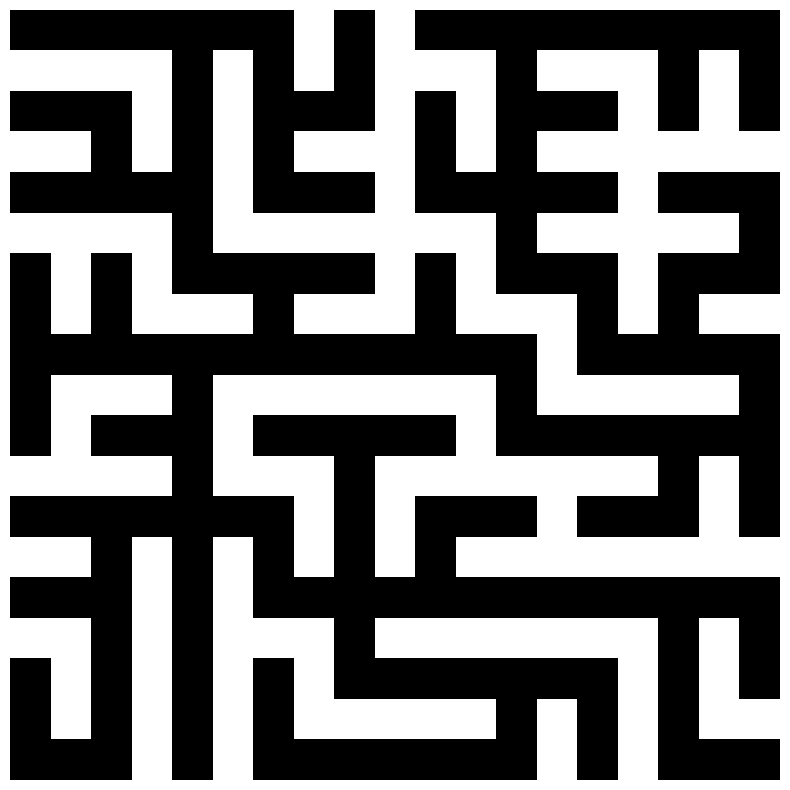

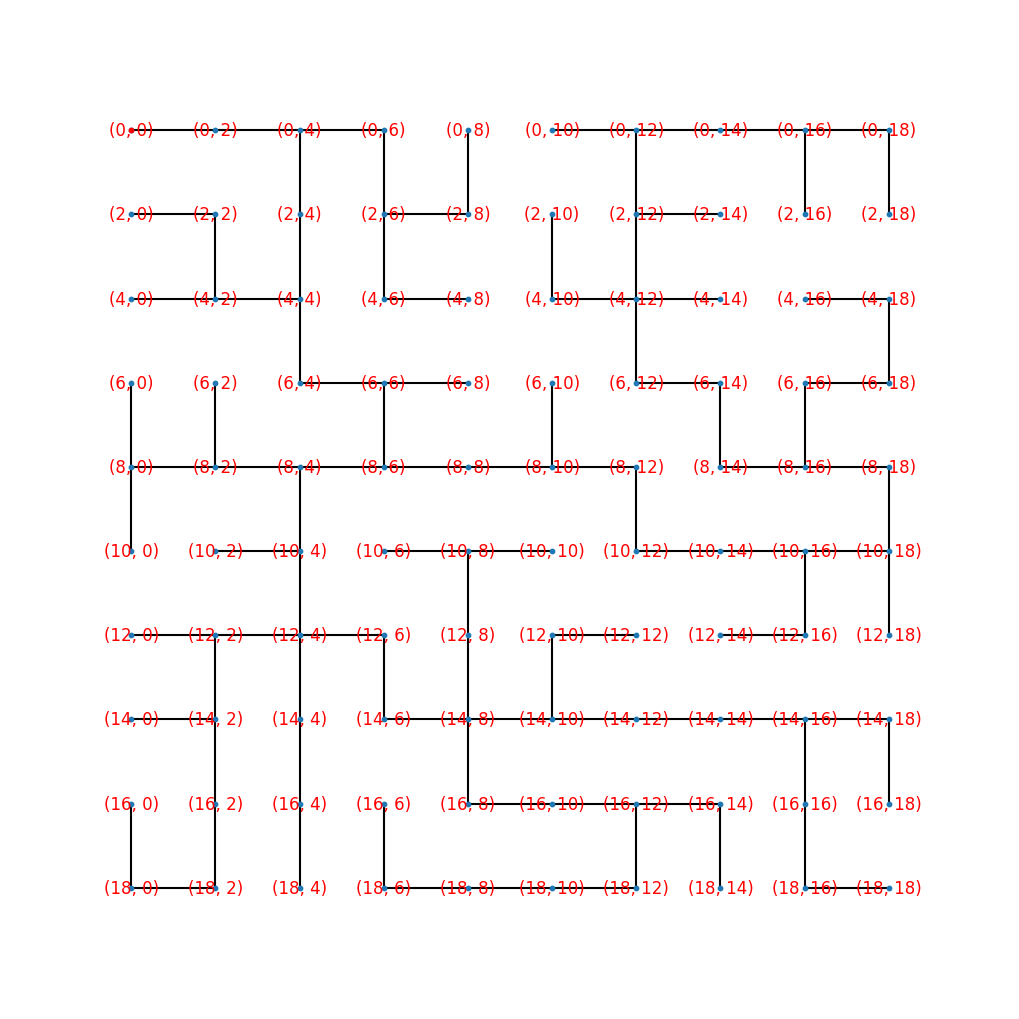

In [54]:
np_maze = convert_to_np(nodes, maze)

plot_maze(np_maze)
print_maze_nx(maze)

In [55]:
print(np_maze)

[[1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.]]

In [56]:
# Use bfs to find the path from the start to the end

def get_neighbours(v, maze):
    x = v[0]
    y = v[1]
    
    neighbours = []
    
    # Check if the node is on the edge of the maze
    if x == 0:
        # Node is on the left edge
        neighbours.append((x + 1, y))
    elif x == maze.shape[0] - 1:
        # Node is on the right edge
        neighbours.append((x - 1, y))
    else:
        # Node is not on the edge
        neighbours.append((x + 1, y))
        neighbours.append((x - 1, y))
        
    if y == 0:
        # Node is on the top edge
        neighbours.append((x, y + 1))
    elif y == maze.shape[1] - 1:
        # Node is on the bottom edge
        neighbours.append((x, y - 1))
    else:
        # Node is not on the edge
        neighbours.append((x, y + 1))
        neighbours.append((x, y - 1))
        
    return neighbours

def bfs(in_maze):
    maze = in_maze.copy()
    Q = []
    
    start = (0, 0)
    end = (maze.shape[0] - 1, maze.shape[1] - 1)
    
    Q.append(start)
    
    prev = {}
    
    while len(Q) > 0:
        v = Q.pop(0)
        
        if v == end:
            return trace_path(prev, end, start)
        
        for n in get_neighbours(v, maze):
            if maze[n] == 1:
                Q.append(n)
                maze[n] = maze[v] - 1
                prev[n] = v
    
    return None

def trace_path(prev, end, start):
    path = [start]
    current = end
    
    while current != start:
        path.append(current)
        current = prev[current]
        
        
    path.append(current)
    
    return path[::-1]

path = bfs(np_maze)

[[2. 2. 2. 2. 2. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 2. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 2. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 2. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 2. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 2. 2. 2. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 2. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 2. 2. 2. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 2. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 2. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 2. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 2. 2. 2.]]

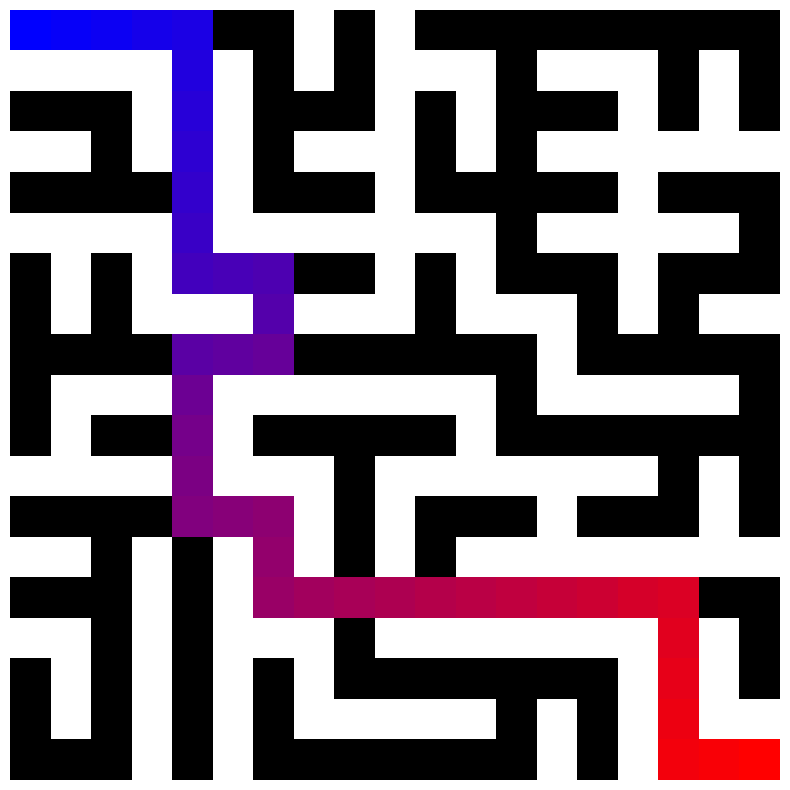

In [57]:
np_maze_with_path = convert_to_np(nodes, maze, path=path)

print(np_maze_with_path)

plot_maze(np_maze_with_path)

In [58]:
import os
os.listdir()

['.git',
 'boruvka_process.gif',
 'Boruvkas Algorithm.ipynb',
 'proof notebook.ipynb',
 'mst.png',
 'real network data',
 'california_road_network_mst.png',
 'city_of_san_joaquin_county_mst.png',
 'README.md',
 'boruvka_process.png']

In [59]:
# Input road data from california in this format
# 0 2418.382812 689.449768
# 1 5983.526367 3650.609131
# 2 9982.622070 7044.406250
# 3 4521.369141 4777.648438
# 4 4469.584961 4777.648438
# 5 4755.921387 4777.648438
# 6 4987.427246 4777.648438

# Read text file
data = []

# Data from here:
# 4. City of San Joaquin County (TG) Road Network
# https://users.cs.utah.edu/~lifeifei/research/tpq/TG.cnode
# https://users.cs.utah.edu/~lifeifei/SpatialDataset.htm

file = 'city_of_san_joaquin_county'

with open(f'real network data/{file}.txt') as f:
    for line in f:
        data.append(line.split())


In [60]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import heapq
import math
import networkx as nx
from tqdm import tqdm

# Function to calculate Euclidean distance
def euclidean_distance(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# Function to find closest nodes for a given node
def find_closest_nodes(node_index, node_degree, data):
    distances = []
    for j in range(len(data)):
        if node_index != j:
            dist = euclidean_distance((data[node_index][1], data[node_index][2]), (data[j][1], data[j][2]))
            heapq.heappush(distances, (dist, j))

    closest_nodes = []
    for _ in range(node_degree):
        if distances:
            _, closest_node = heapq.heappop(distances)
            closest_nodes.append((data[node_index][0], data[closest_node][0], distances[0][0]))

    return closest_nodes

# Convert data to floats and create graph
data = [(int(node[0]), float(node[1]), float(node[2])) for node in data]
G = nx.Graph()
for node in data:
    G.add_node(node[0], pos=(node[1], node[2]))

node_degree = 20

# Parallel processing
edges_to_add = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(find_closest_nodes, i, node_degree, data) for i in range(len(data))]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing edges"):
        edges_to_add.extend(future.result())

# Add edges
for edge in edges_to_add:
    G.add_edge(edge[0], edge[1], weight=edge[2])


Processing edges:   0%|          | 1/18263 [00:00<40:08,  7.58it/s]

Processing edges: 100%|██████████| 18263/18263 [00:54<00:00, 333.01it/s]


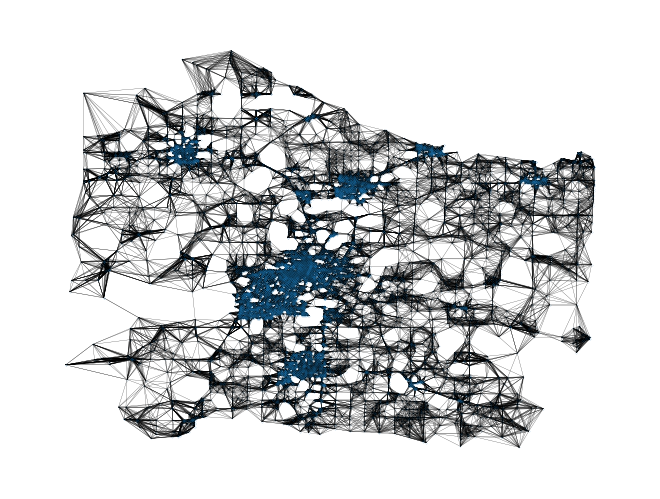

In [61]:
# Output the graph
pos = nx.get_node_attributes(G, 'pos')

# nx.draw(G, pos, node_size=10, with_labels=True, font_size=12, width=1.5, font_color='red')
# plt.show()

# Draw the graph
nx.draw(G, pos, with_labels=False, node_size=.005, width=.15)
plt.savefig(f'real network data/{file}.png', dpi=1600)
plt.show()

In [62]:
# Extract nodes and their positions
nodes = {n: (x, y) for n, (x, y) in nx.get_node_attributes(G, 'pos').items()}

# Convert nodes to a simple list of node IDs
node_ids = list(nodes.keys())

# Extract edges and their weights
edges = {edge: G[edge[0]][edge[1]]['weight'] for edge in G.edges()}

# Convert the edges to use node IDs instead of positions
converted_edges = {(node_ids.index(edge[0]), node_ids.index(edge[1])): weight for edge, weight in edges.items()}

# Now, pass these converted nodes and edges to your Boruvka function
mst = boruvka(node_ids, converted_edges, animation=False, show_figure=False, progress=True)

Converting networkx graph to a simple list of nodes and edges...

Calculating number of iterations...

  0%|          | 0/18262 [00:00<?, ?it/s]

Running Boruvka's Algorithm...

100%|██████████| 18262/18262 [06:08<00:00, 49.55it/s]


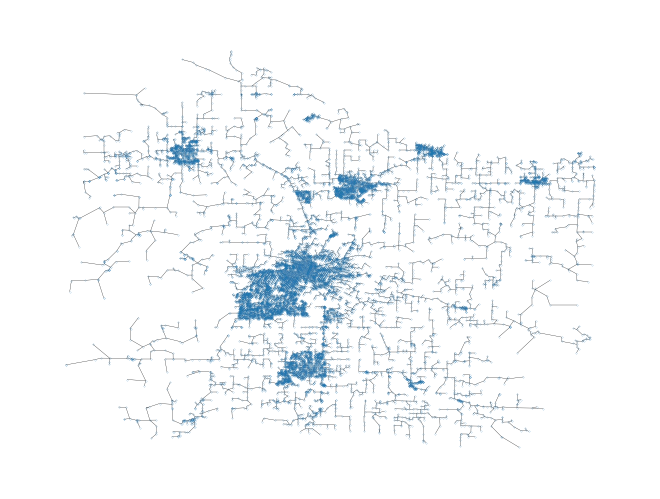

In [66]:
# To visualize the MST, create a new NetworkX graph
mst_graph = nx.Graph()
mst_graph.add_nodes_from(node_ids)
mst_graph.add_edges_from(mst.keys())

# Use original positions for drawing
original_pos = {node_ids[i]: pos for i, pos in enumerate(nx.get_node_attributes(G, 'pos').values())}
nx.draw(mst_graph, original_pos, with_labels=False, node_size=.01, width=.2)
plt.savefig(f'{file.lower()}_mst.png', dpi=1600)
plt.show()

In [67]:
# Get the total weight of the original graph
total_weight = sum(edges.values())
print(f'Total weight of original graph: {total_weight}')

# Get the total weight of the MST
mst_weight = sum(mst.values())
print(f'Total weight of MST: {mst_weight}')

Total weight of original graph: 17267291.80865014

Total weight of MST: 575922.3832500906

In [65]:
# import networkx as nx
# import matplotlib.pyplot as plt

# data = []

# with open('real network data\city_of_san_joaquin_county_with_edges.txt') as f:
#     for line in f:
#         data.append(line.split())

# print(data[:10])

# # Create a graph
# G = nx.Graph()

# # Parse the data and add edges to the graph
# for line in data:
#     _, start, end, weight = line
#     G.add_edge(int(start), int(end), weight=float(weight))

# # Calculate total edge weight
# total_weight = sum([data['weight'] for _, _, data in G.edges(data=True)])
# print("Total Edge Weight:", total_weight)
